# PCB Defect Detection with YOLOv8 🔍

**Before running:** Go to `Runtime` → `Change runtime type` → Select `T4 GPU`


In [1]:
# Step 1: Check GPU
!nvidia-smi


Sun Dec  7 21:23:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Step 2: Install dependencies
!pip install -q ultralytics kagglehub


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.8 MB/s eta 0:00:00


In [3]:
# Step 3: Setup Kaggle credentials
from google.colab import files
import os

# Create .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Upload your kaggle.json file (download from https://www.kaggle.com/settings)
print("Upload your kaggle.json file:")
uploaded = files.upload()

# Move to correct location
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
print("✅ Kaggle credentials configured!")


Upload your kaggle.json file:


Saving kaggle.json to kaggle.json
✅ Kaggle credentials configured!


In [4]:
# Step 4: Download the PCB Defects dataset
import kagglehub

dataset_path = kagglehub.dataset_download("akhatova/pcb-defects")
print(f"Dataset downloaded to: {dataset_path}")


100%|██████████| 1.88G/1.88G [00:47<00:00, 42.1MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/akhatova/pcb-defects/versions/1


In [5]:
# Step 5: Convert VOC annotations to YOLO format
import xml.etree.ElementTree as ET
from pathlib import Path
import shutil
import random

# Paths
DATA_DIR = Path(dataset_path) / "PCB_DATASET"
OUTPUT_DIR = Path("/content/yolo_dataset")

# Create output directories
for split in ['train', 'val', 'test']:
    (OUTPUT_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
    (OUTPUT_DIR / 'labels' / split).mkdir(parents=True, exist_ok=True)

# Class mapping
CLASSES = ["missing_hole", "mouse_bite", "open_circuit", "short", "spur", "spurious_copper"]
CLASS_TO_IDX = {cls: idx for idx, cls in enumerate(CLASSES)}

def parse_voc_annotation(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    filename = root.find("filename").text
    size = root.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)
    objects = []
    for obj in root.findall("object"):
        name = obj.find("name").text.lower()
        bbox = obj.find("bndbox")
        objects.append({
            "name": name,
            "xmin": int(bbox.find("xmin").text),
            "ymin": int(bbox.find("ymin").text),
            "xmax": int(bbox.find("xmax").text),
            "ymax": int(bbox.find("ymax").text)
        })
    return filename, width, height, objects

def convert_to_yolo(obj, img_width, img_height):
    class_name = obj["name"].replace(" ", "_")
    class_idx = CLASS_TO_IDX.get(class_name, -1)
    if class_idx == -1:
        return None
    x_center = (obj["xmin"] + obj["xmax"]) / 2 / img_width
    y_center = (obj["ymin"] + obj["ymax"]) / 2 / img_height
    width = (obj["xmax"] - obj["xmin"]) / img_width
    height = (obj["ymax"] - obj["ymin"]) / img_height
    return f"{class_idx} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

# Collect all samples
samples = []
for class_dir in (DATA_DIR / "Annotations").iterdir():
    if not class_dir.is_dir():
        continue
    for xml_file in class_dir.glob("*.xml"):
        img_path = DATA_DIR / "images" / class_dir.name / (xml_file.stem + ".jpg")
        if img_path.exists():
            samples.append((img_path, xml_file))

print(f"Found {len(samples)} samples")

# Shuffle and split
random.seed(42)
random.shuffle(samples)
n_train = int(len(samples) * 0.7)
n_val = int(len(samples) * 0.2)

splits = [
    ("train", samples[:n_train]),
    ("val", samples[n_train:n_train + n_val]),
    ("test", samples[n_train + n_val:])
]

for split_name, split_samples in splits:
    for img_path, xml_path in split_samples:
        filename, width, height, objects = parse_voc_annotation(xml_path)
        yolo_lines = [convert_to_yolo(obj, width, height) for obj in objects]
        yolo_lines = [l for l in yolo_lines if l]

        new_name = f"{xml_path.parent.name}_{xml_path.stem}"
        shutil.copy(img_path, OUTPUT_DIR / "images" / split_name / f"{new_name}.jpg")
        with open(OUTPUT_DIR / "labels" / split_name / f"{new_name}.txt", "w") as f:
            f.write("\n".join(yolo_lines))
    print(f"{split_name}: {len(split_samples)} images")

print("✅ Dataset converted!")


Found 693 samples
train: 485 images
val: 138 images
test: 70 images
✅ Dataset converted!


In [6]:
# Step 6: Create YOLO config file
yaml_content = """# PCB Defects Dataset
path: /content/yolo_dataset
train: images/train
val: images/val
test: images/test

names:
  0: missing_hole
  1: mouse_bite
  2: open_circuit
  3: short
  4: spur
  5: spurious_copper

nc: 6
"""

with open("/content/pcb_defects.yaml", "w") as f:
    f.write(yaml_content)

print("✅ Config file created!")


✅ Config file created!


In [7]:
# Step 7: Train YOLOv8 🚀
from ultralytics import YOLO

# Load pretrained model
model = YOLO("yolov8s.pt")

# Train
results = model.train(
    data="/content/pcb_defects.yaml",
    epochs=50,
    imgsz=640,
    batch=16,  # Can use larger batch on T4
    patience=15,
    device=0,  # Use GPU
    project="/content/runs",
    name="pcb_yolov8s",
    exist_ok=True,
    plots=True,
    mosaic=1.0,
    mixup=0.1,
    degrees=10.0,
    scale=0.5,
    fliplr=0.5,
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/pcb_defects.yaml, degrees=10.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, 

In [8]:
# Step 8: Evaluate on test set
model = YOLO("/content/runs/pcb_yolov8s/weights/best.pt")

metrics = model.val(
    data="/content/pcb_defects.yaml",
    split="test",
    plots=True
)

print(f"\n{'='*50}")
print("Test Results")
print(f"{'='*50}")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,127,906 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4093.6±927.4 MB/s, size: 1412.8 KB)
val: Scanning /content/yolo_dataset/labels/test... 70 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 70/70 1.5Kit/s 0.0s
val: New cache created: /content/yolo_dataset/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 5/5 1.0s/it 5.1s
                   all         70        290      0.968      0.894      0.943      0.497
          missing_hole         11         48          1      0.972       0.99      0.553
            mouse_bite         11         42      0.958      0.762      0.864      0.459
          open_circuit          9         38      0.973      0.966      0.974      0.482
                 short         17         66      0.983      0.898      0.991 

In [9]:
# Step 9: Download trained model
from google.colab import files

# Download best weights
files.download("/content/runs/pcb_yolov8s/weights/best.pt")
print("✅ Model downloaded!")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model downloaded!



image 1/1 /content/yolo_dataset/images/test/Spurious_copper_04_spurious_copper_04.jpg: 544x640 3 spurious_coppers, 15.9ms
Speed: 14.3ms preprocess, 15.9ms inference, 4.2ms postprocess per image at shape (1, 3, 544, 640)


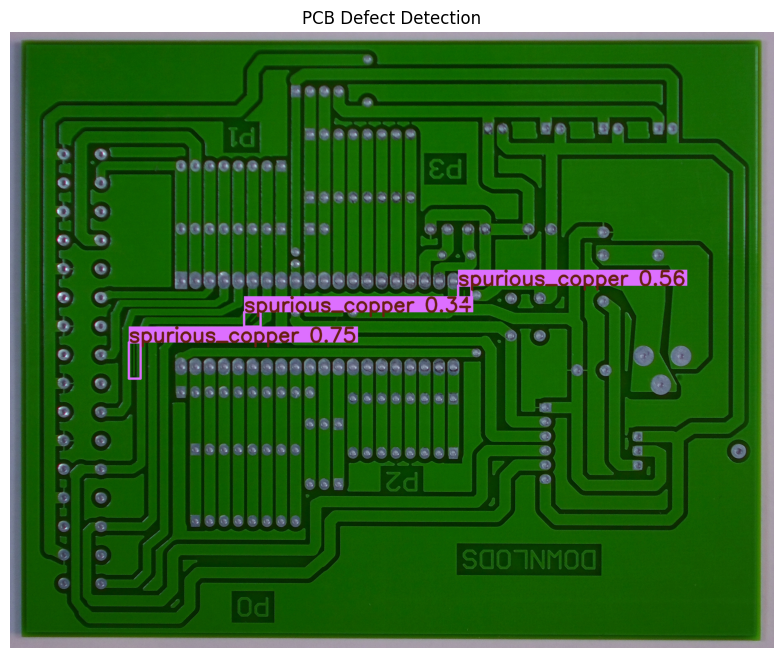

In [11]:
# Optional: Test on a sample image
from pathlib import Path
import matplotlib.pyplot as plt

# Get a test image
test_images = list(Path("/content/yolo_dataset/images/test").glob("*.jpg"))
if test_images:
    results = model.predict(test_images[0], conf=0.30)

    # Display result
    plt.figure(figsize=(12, 8))
    plt.imshow(results[0].plot())
    plt.axis('off')
    plt.title('PCB Defect Detection')
    plt.show()
